In [1]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [2]:
import pandas as pd
import numpy as np

In [3]:
d1 = pd.read_csv('sentiment_tweets3.csv')
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB


In [4]:
d1 = d1.rename(columns={'message to examine':'body','label (depression result)':'Depressed'})

In [5]:
d1.Depressed.value_counts()

0    8000
1    2314
Name: Depressed, dtype: int64

In [6]:
d2 = pd.read_csv('Data.csv')
d2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1912 non-null   object 
 1   score         1912 non-null   int64  
 2   id            1912 non-null   object 
 3   subreddit     1912 non-null   object 
 4   url           1912 non-null   object 
 5   num_comments  1912 non-null   int64  
 6   body          1912 non-null   object 
 7   created       1912 non-null   float64
 8   Depressed     1912 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 134.6+ KB


In [7]:
d2 = d2.rename(columns={'label (depression result)':'Depressed', 'message to examine': 'body'})

In [8]:
d2

,title,score,id,subreddit,url,num_comments,body,created,Depressed
0,Our most-broken and least-understood rules is ...,2323,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,175,We understand that most people who reply immed...,1.572361e+09,1
1,"Regular Check-In Post, with important reminder...",672,m246c4,depression,https://www.reddit.com/r/depression/comments/m...,2584,Welcome to /r/depression's check-in post - a p...,1.615400e+09,1
2,Work is a perfect reason to commit suicide,628,oyqbtv,depression,https://www.reddit.com/r/depression/comments/o...,102,It sucks and it will be the majority of your l...,1.628193e+09,1
3,anyone else at their lowest?,63,oyxdxb,depression,https://www.reddit.com/r/depression/comments/o...,20,these past 3 days have been rough. I have new ...,1.628216e+09,1
4,Im burned out.,22,oz056o,depression,https://www.reddit.com/r/depression/comments/o...,4,Im so fucking tired of everything. Had a panic...,1.628227e+09,1
...,...,...,...,...,...,...,...,...,...
1907,What's something you do when noone is looking?,3,oz04n9,AskReddit,https://www.reddit.com/r/AskReddit/comments/oz...,12,What's something you do when noone is looking?,1.628227e+09,0
1908,If you had to eat one type of canned food for ...,6,oyxjy0,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,23,If you had to eat one type of canned food for ...,1.628217e+09,0
1909,"People of Reddit, what do you think of virtue ...",4,oyypzt,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,"People of Reddit, what do you think of virtue ...",1.628221e+09,0
1910,Who or what do you trust the most?,6,oyuxy4,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,Who or what do you trust the most?,1.628207e+09,0


In [9]:
d2.Depressed.value_counts()

0    996
1    916
Name: Depressed, dtype: int64

In [10]:
d1 = d1[['body','Depressed']]
d2 = d2[['body','Depressed']]
df = pd.concat([d1,d2])
df

,body,Depressed
0,just had a real good moment. i missssssssss hi...,0
1,is reading manga http://plurk.com/p/mzp1e,0
2,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,@lapcat Need to send 'em to my accountant tomo...,0
4,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0
...,...,...
1907,What's something you do when noone is looking?,0
1908,If you had to eat one type of canned food for ...,0
1909,"People of Reddit, what do you think of virtue ...",0
1910,Who or what do you trust the most?,0


In [11]:
df.Depressed.value_counts()

0    8996
1    3230
Name: Depressed, dtype: int64

In [12]:
import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

In [13]:
import re
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    text = " ".join(words)
    return text
  

df['body'] = df['body'].apply(clean_text)
df['body'] = df['body'].str.replace('\d+', '')

In [14]:
df

,body,Depressed
0,real good moment missssssssss,0
1,reading manga http plurkcom p mzpe,0
2,comeagainjen http twitpiccom yl http wwwyoutub...,0
3,lapcat need send em accountant tomorrow oddly ...,0
4,add myspace myspacecom lookthunder,0
...,...,...
12221,whats looking,0
12222,eat type canned food rest life choosing,0
12223,people reddit think virtue signalling fau outr...,0
12224,trust,0


In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27141 unique tokens.


In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (12226, 250)


In [17]:
Y = pd.get_dummies(df['Depressed']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (12226, 2)


In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11003, 250) (11003, 2)
(1223, 250) (1223, 2)


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 1024

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
10/10 [==============================] - 87s 8s/step - loss: 0.6279 - accuracy: 0.7215 - val_loss: 0.5071 - val_accuracy: 0.7557
Epoch 2/5
10/10 [==============================] - 78s 8s/step - loss: 0.4793 - accuracy: 0.7529 - val_loss: 0.4023 - val_accuracy: 0.8247
Epoch 3/5
10/10 [==============================] - 78s 8s/step - loss: 0.3859 - accuracy: 0.8611 - val_loss: 0.3369 - val_accuracy: 0.8865
Epoch 4/5
10/10 [==============================] - 78s 8s/step - loss: 0.3181 - accuracy: 0.8957 - val_loss: 0.2730 - val_accuracy: 0.9055
Epoch 5/5
10/10 [==============================] - 78s 8s/step - loss: 0.2325 - accuracy: 0.9270 - val_loss: 0.1972 - val_accuracy: 0.9437


In [20]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

39/39 [==============================] - 3s 79ms/step - loss: 0.2281 - accuracy: 0.9248
Test set
  Loss: 0.228
  Accuracy: 0.925


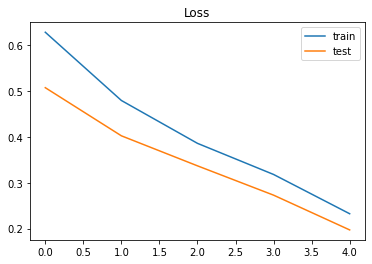

In [21]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

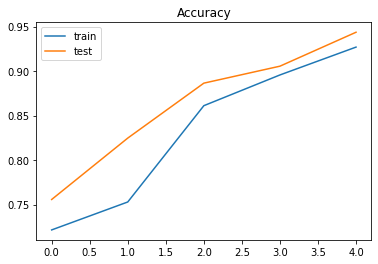

In [22]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [34]:
val = pd.read_csv('shot1.csv')

In [35]:
val

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
1994,2983,Was doing math And today it was equations with...,non-suicide
1995,2984,I have called the suicide hotline and used cri...,suicide
1996,2985,LEAVE ME THE FUCK ALONEI HAVEN'T DONE ANYTHING...,suicide
1997,2988,I just dont know I just feel nothing when i ta...,non-suicide


In [36]:
val['Depressed'] = 0
for i in range(len(val)):
  if(val.loc[i,'class'] == 'suicide'):
    val.loc[i,'Depressed'] = 1
val = val.rename(columns = {'text':'body'})
val = val[['body','Depressed']]

In [37]:
val

,body,Depressed
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...
1994,Was doing math And today it was equations with...,0
1995,I have called the suicide hotline and used cri...,1
1996,LEAVE ME THE FUCK ALONEI HAVEN'T DONE ANYTHING...,1
1997,I just dont know I just feel nothing when i ta...,0


In [38]:
val['body'] = val['body'].apply(clean_text)
val['body'] = val['body'].str.replace('\d+', '')
tokenizer.fit_on_texts(val['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X1 = tokenizer.texts_to_sequences(val['body'].values)
X1 = pad_sequences(X1, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X1.shape)
Y1 = pd.get_dummies(val['Depressed']).values
print('Shape of label tensor:', Y1.shape)

Found 33858 unique tokens.
Shape of data tensor: (1999, 250)
Shape of label tensor: (1999, 2)


In [39]:
accr = model.evaluate(X1,Y1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

63/63 [==============================] - 5s 86ms/step - loss: 0.7121 - accuracy: 0.6503
Test set
  Loss: 0.712
  Accuracy: 0.650


In [40]:
def isDepressing(text):
  lst = {'body':[text]}
  # Calling DataFrame constructor on list  
  dframe = pd.DataFrame(lst) 
  dframe = dframe['body'].apply(clean_text)
  dframe = dframe.str.replace('\d+', '')
  tokenizer.fit_on_texts(dframe.values)
  word_index = tokenizer.word_index
  print('Found %s unique tokens.' % len(word_index))
  X1 = tokenizer.texts_to_sequences(dframe.values)
  X1 = pad_sequences(X1, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', X1.shape)
  a = model.predict(X1)
  print(a)
  if(a[0][0] > a[0][1]):
    return 0
  return 1

In [41]:
isDepressing('responsible  ive been running this through my mind for far too long and i need an external opinion without anyone getting worried or equally socially devastatingsay someone rapes their wifegirlfriend non violent but repeat offense what is the best course of action from the rapistobviously the first step would be to leave the person alone and go nocontact permanently but from there what what justice is servedis it on the rapist to live with the guilt and the full weight of their actions and crimes for the rest of their lives are they to face trial and conviction is it their responsibility to kill themselves so as not to harm another individual againethically speaking how is proper justice served here because i want justice')

Found 33866 unique tokens.
Shape of data tensor: (1, 250)
[[0.44967657 0.55032337]]


1